<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº8
#### Carola Piazze Vicini y Kala Ariadna Guevara


# Introducción
Una de las herramientas más esenciales en el área de medicina es el electrocardiograma (ECG). Este permite realizar un diagnóstico cardíaco a través de la visualización de la actividad eléctrica del corazón. No obstante, la señal presenta frecuentemente alteraciones que comprometen su calidad, como por ejemplo: el mal posicionamiento de electrodos, movimiento muscular o movimiento del tórax debido a la respiración. Todas estas alteraciones de baja frecuencia comprometen la línea de base, ya que pueden ocultar las características morfológicas esenciales del ECG, dificultando su interpretación clínica.

Por ende, surgió la necesidad de obtener trazados limpios y estables, lo cual se logra a través del desarrollo de técnicas de filtrado digital que permitan eliminar componentes espectrales no deseados mientras se preserva la información fisiológica relevante. Estudios previos de análisis espectral han establecido los rangos frecuenciales característicos de las distintas ondas que componen el ciclo cardíaco, proporcionando así los fundamentos para definir especificaciones de diseño de filtros adaptadas a las particularidades de la señal electrocardiográfica.

El presente trabajo se enfoca en el desarrollo y evaluación comparativa de diferentes estrategias de filtrado digital, considerando tanto aproximaciones FIR (Respuesta Finita al Impulso) como IIR (Respuesta Infinita al Impulso). Entre las técnicas IIR se exploran aproximaciones clásicas como Butterworth, reconocida por su respuesta plana en la banda de paso, y Cauer (elíptico), que optimiza simultáneamente la selectividad y la atenuación en banda rechazada. Por otro lado, para los filtros FIR se implementan métodos basados en ventanas y optimización por mínimos cuadrados. El objetivo principal consiste en ajustar la respuesta frecuencial de cada diseño a una plantilla predefinida que garantice la atenuación efectiva de interferencias sin distorsionar los componentes morfológicos del ECG. La evaluación del desempeño se realiza tanto en el dominio frecuencial, analizando las características de cada filtro, como en el dominio temporal, aplicándolos a registros reales de ECG para verificar su capacidad de mejorar la calidad de la señal manteniendo la integridad de la información clínica relevante.

### Conceptos Fundamentales de la Plantilla de Filtro
La plantilla de un filtro representa una especificación técnica completa que establece los requisitos de comportamiento en el dominio frecuencial. Esta herramienta de diseño delimita con precisión las regiones operativas fundamentales que determinan el desempeño del filtro:

- Banda de Paso (Passband): Comprende el rango desde frecuencia cero hasta ωp, donde el filtro debe permitir el paso de las componentes de señal con una atenuación mínima. En esta región, la magnitud de la respuesta se mantiene cercana a la unidad, permitiendo únicamente pequeñas variaciones controladas por el parámetro δ₁, conocido como ripple o rizado máximo permitido. Para aplicaciones biomédicas como el filtrado de ECG, mantener un ripple reducido es crucial para preservar la morfología original de las ondas cardíacas.

- Banda de Transición: Definida por el intervalo Δω = ωs - ωp, constituye la zona donde ocurre la transición gradual entre la banda de paso y la banda de rechazo. La pendiente de esta transición determina en gran medida la complejidad del filtro - transiciones más abruptas generalmente requieren órdenes de filtro más elevados y, consecuentemente, mayor carga computacional.

- Banda de Rechazo (Stopband): Se extiende desde ωs hacia frecuencias superiores, donde el filtro debe proporcionar una atenuación significativa de las componentes no deseadas. El parámetro δ₂ especifica el nivel máximo de señal permitido en esta banda, asegurando que las interferencias y ruidos sean suficientemente suprimidos.

### Parámetros de Especificación
Frecuencias Características:
- ωp: Frecuencia de borde de la banda de paso - define el límite superior donde la señal aún se considera útil
- ωs: Frecuencia de borde de la banda de rechazo - establece el punto donde debe comenzar la atenuación significativa

Tolerancias de Diseño: 
- δ₁ (rizado de banda de paso): Máxima variación permitida en la magnitud dentro de la banda de paso
- δ₂ (rizado de banda de rechazo): Nivel máximo de señal permitido en la banda de rechazo

Ancho de Banda de Transición:
- Δω = ωs - ωp: Representa el rango frecuencial donde ocurre la transición entre paso y rechazo

<img src="./plantilla.jpg" align="left" width="600" /> 

# Desarrollo
Para evaluar diferentes estrategias de filtrado digital aplicadas a señales ECG reales, se implementaron y compararon filtros IIR y FIR bajo especificaciones de banda pasante y banda de rechazo fijadas según la literatura.

En la primera etapa se diseñaron filtros IIR Butterworth y Cauer, utilizando la función iirdesign con salida en formato SOS. Para cada diseño se calcularon la respuesta en frecuencia, fase y retardo de grupo, y se verificó el cumplimiento de la plantilla mediante plot_plantilla. Cada filtro fue aplicado a la derivación ECG mediante sosfiltfilt, analizando su efecto tanto sobre el registro completo como sobre regiones específicas con y sin presencia de ruido.

En la segunda etapa se diseñaron filtros FIR mediante firwin2 y cuadrados mínimos firls. Se estimaron coeficientes con longitud suficientemente grande para garantizar fase lineal, y se evaluaron sus respuestas frecuenciales, incluida la linealidad de fase y el retardo de grupo. Para el procesado temporal se utilizó lfilter, compensando el retardo introducido por cada diseño. Los filtros FIR también fueron aplicados a las mismas regiones del ECG para permitir una comparación directa con sus equivalentes IIR.

# PARTE IIR: Código y gráficos 

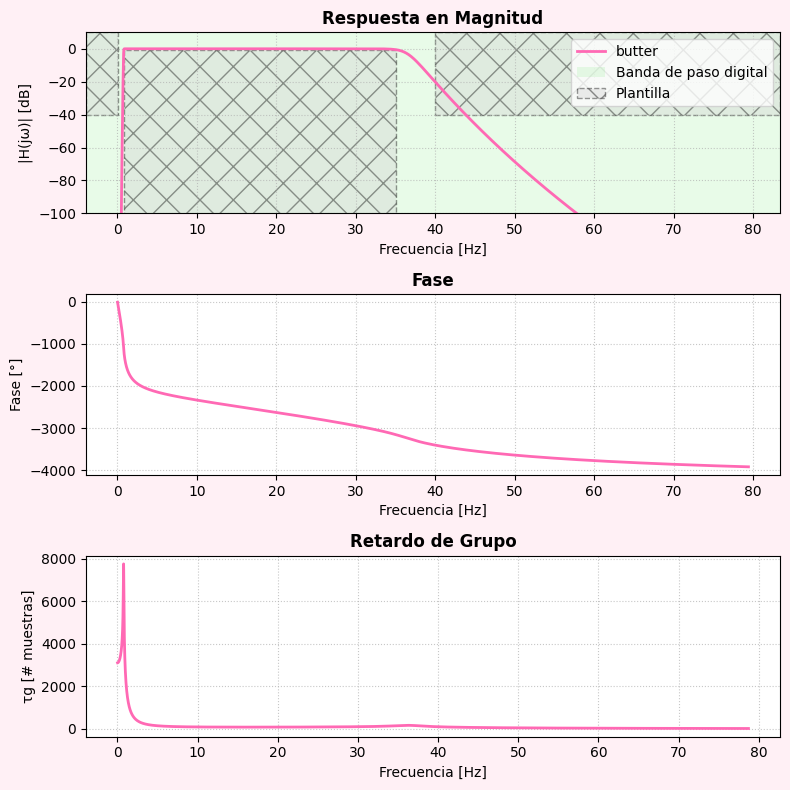

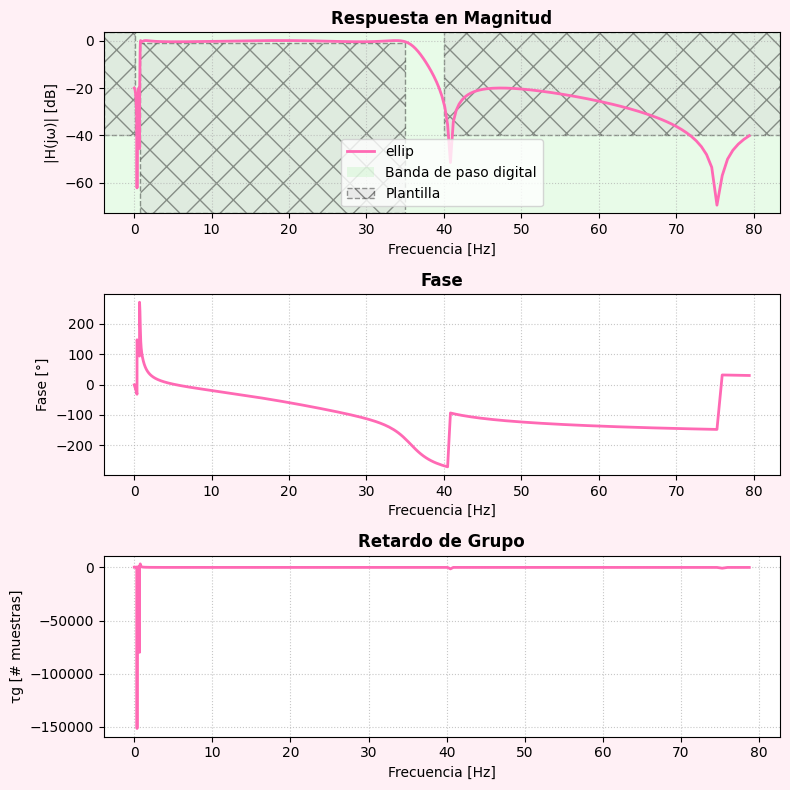

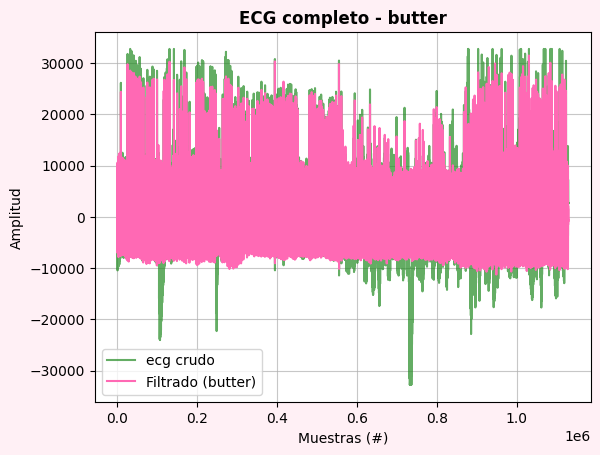

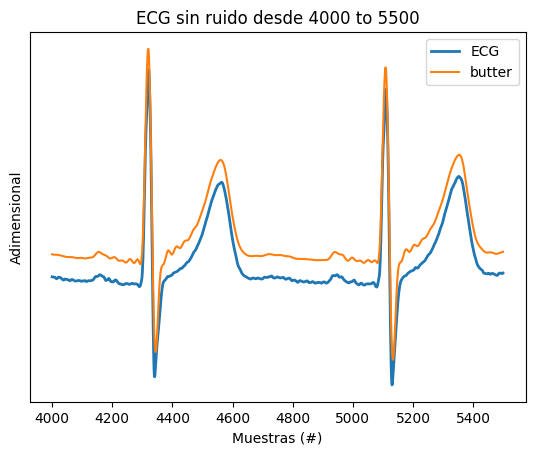

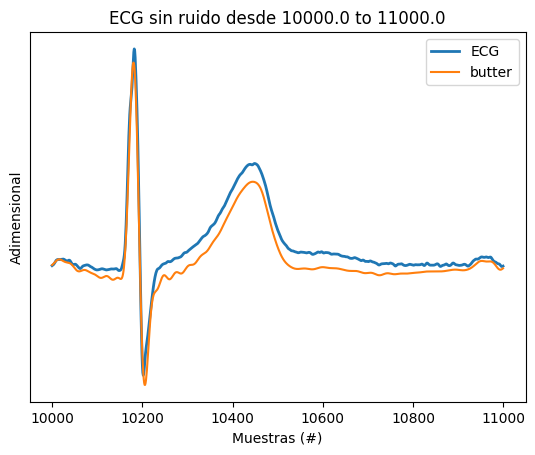

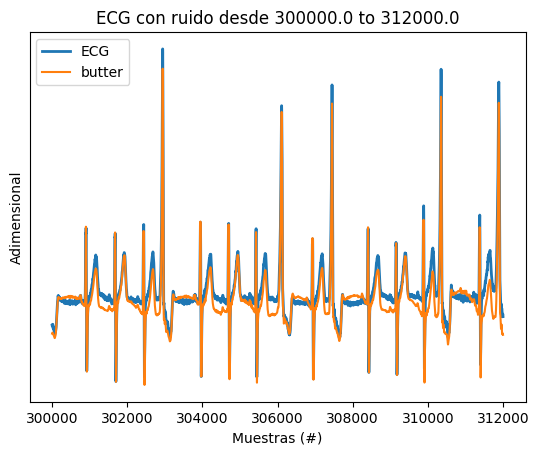

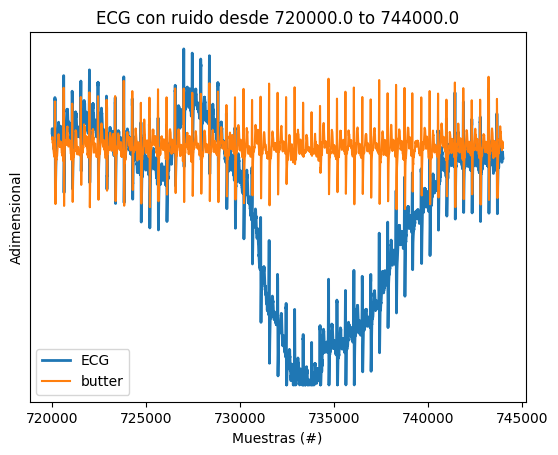

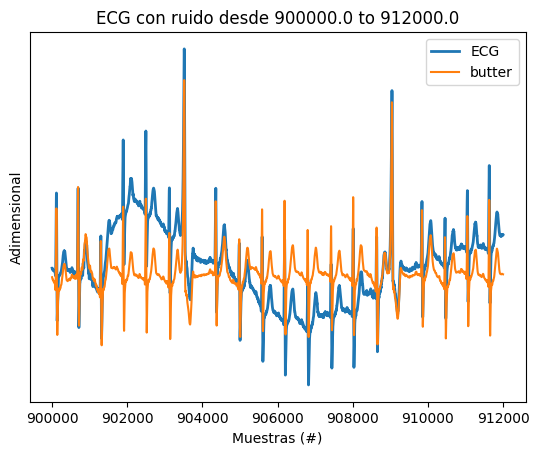

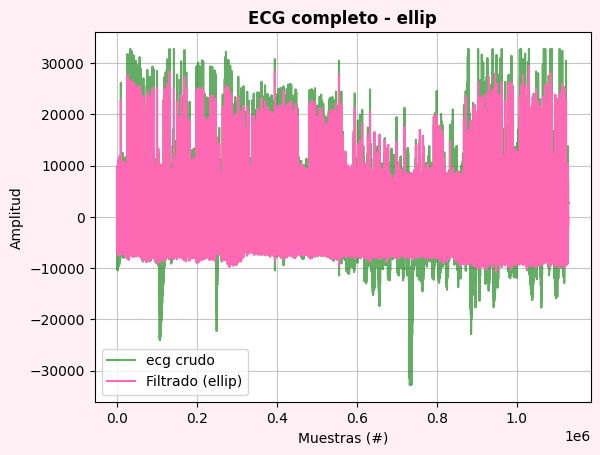

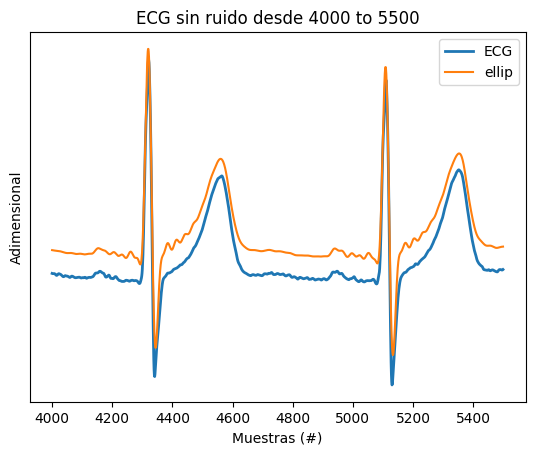

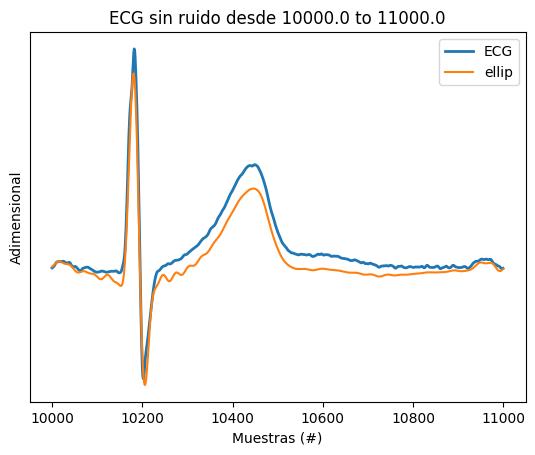

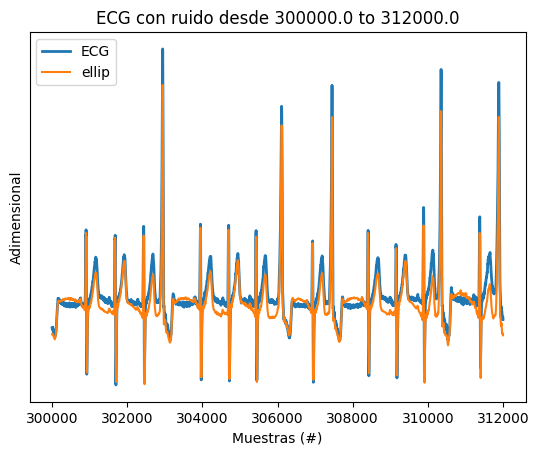

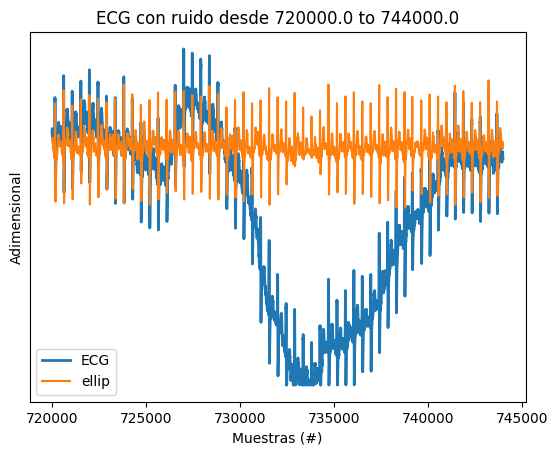

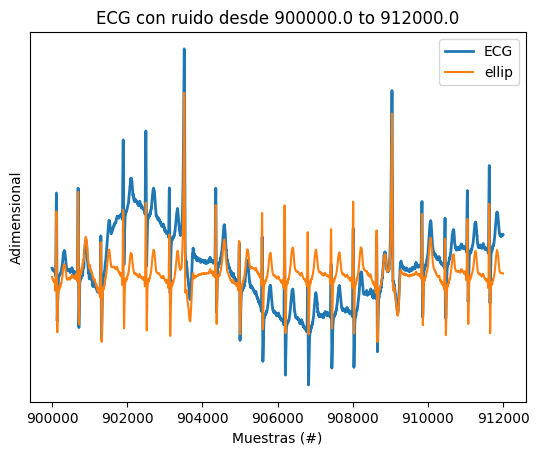

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  4 12:48:32 2025

@author: gueva
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla
import warnings
warnings.filterwarnings("ignore", message="Badly conditioned filter coefficients")
#%% CAMBIOS ESTETICOS
plt.style.use('default')  #se resetea
#defino colores
COLOR_FONDO = '#FFF0F5'  
COLOR_VERDE = '#2E8B57'   
COLOR_ROSA = '#FF69B4'    

# %% VARIABLES IIR PARA LA PLANTILLA

fs = 1000 # Hz
fs_ecg = 1000 # Hz
wp = (0.8, 35) #frecuencia de paso
ws = (0.1, 40) #frecuencia de rechazo 
alpha_p = 1/2 #atenuacion de banda de paso / el alfa maximo
alpha_s = 40/2 #atenuacion de banda de rechazo / el alfa minimo

#abro archivo
mat_struct = sio.loadmat('./ecg.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)

#%%
def filtro_IIR(fs, wp, ws, alpha_p, alpha_s, ftype): 
    
    mi_sos = signal.iirdesign(wp = wp, ws = ws, gpass = alpha_p, gstop = alpha_s, analog = False, ftype = ftype, output ='sos', fs=fs)
    
    #calculo rta en frec
    w, h= signal.freqz_sos(mi_sos, worN = np.logspace(-2, 1.9, 1000), fs = fs)
    fase = np.unwrap(np.angle(h)) 
    w_rad = w / (fs / 2) * np.pi
    gd = -np.diff(fase) / np.diff(w_rad) 
    
    #politos y ceritos con la funcion que vimos
    z, p, k = signal.sos2zpk(mi_sos)
    
    #magnitud
    plt.figure(figsize=(8, 8))
    plt.subplot(3,1,1)
    plt.plot(w, 20 * np.log10(np.maximum(abs(h), 1e-10)), 
             label=ftype, color=COLOR_ROSA, linewidth=2)
    plot_plantilla(filter_type='bandpass', fpass=wp, ripple=alpha_p*2, 
                   fstop=ws, attenuation=alpha_s*2, fs=fs)
    plt.title('Respuesta en Magnitud', fontweight='bold')
    plt.ylabel('|H(jω)| [dB]')
    plt.xlabel('Frecuencia [Hz]')
    plt.grid(True, which='both', ls=':', alpha=0.7)
    plt.legend()

    #fase
    plt.subplot(3,1,2)
    plt.plot(w, np.degrees(fase), color=COLOR_ROSA, linewidth=2)
    plt.title('Fase', fontweight='bold')
    plt.ylabel('Fase [°]')
    plt.xlabel('Frecuencia [Hz]')
    plt.grid(True, which='both', ls=':', alpha=0.7)
    
    #retardo de grupo
    plt.subplot(3,1,3)
    plt.plot(w[:-1], gd, color=COLOR_ROSA, linewidth=2)
    plt.title('Retardo de Grupo', fontweight='bold')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [# muestras]')
    plt.grid(True, which='both', ls=':', alpha=0.7)
    
    #pone fondito pink
    plt.gcf().patch.set_facecolor(COLOR_FONDO)
    plt.tight_layout()
    plt.show()
    
    return mi_sos

def filtrar_IIR_ECG(mi_sos, nombre_filtro, ecg=ecg_one_lead, fs=fs_ecg):
    ecg_filt = signal.sosfiltfilt(mi_sos, ecg)

    plt.figure()
    plt.plot(ecg, label='ecg crudo', alpha=0.7, color='forestgreen')
    plt.plot(ecg_filt, label=f'Filtrado ({nombre_filtro})', 
             linewidth=1.5, color=COLOR_ROSA)
    plt.title(f'ECG completo - {nombre_filtro}', fontweight='bold')
    plt.xlabel('Muestras (#)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True, alpha=0.7)
    plt.gcf().patch.set_facecolor(COLOR_FONDO)
    plt.show()
    
#COPY PASTE DE LA PARTE DE MARIANO DEL CAMPUS
    #################################
    # Regiones de interés sin ruido #
    #################################
    
    cant_muestras = len(ecg_one_lead)
    
    regs_interes = (
            [4000, 5500], # muestras
            [10e3, 11e3], # muestras
            )
     
    for ii in regs_interes:
       
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
       
        plt.figure()
        plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, ecg_filt[zoom_region], label=nombre_filtro)
        #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
       
        plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
       
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
               
        plt.show()
     
    #################################
    # Regiones de interés con ruido #
    #################################
     
    regs_interes = (
            np.array([5, 5.2]) *60*fs, # minutos a muestras
            np.array([12, 12.4]) *60*fs, # minutos a muestras
            np.array([15, 15.2]) *60*fs, # minutos a muestras
            )
     
    for ii in regs_interes:
       
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
       
        plt.figure()
        plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, ecg_filt[zoom_region], label=nombre_filtro)
        # plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
       
        plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
       
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
               
        plt.show()

#para comparar ambos filtros fir
tipos_iir = ['butter', 'ellip']  #ellip es la cauer
resultados_iir = {}

for tipo_actual in tipos_iir:
    coeficientes_sos = filtro_IIR(
        fs=fs,
        wp=wp, 
        ws=ws,
        alpha_p=alpha_p,
        alpha_s=alpha_s,
        ftype=tipo_actual
    )
    resultados_iir[tipo_actual] = coeficientes_sos

#filtro cada metodo
for nombre_tipo, coef_sos in resultados_iir.items():
    filtrar_IIR_ECG(coef_sos, nombre_tipo)

# PARTE FIR: Código y gráficos 

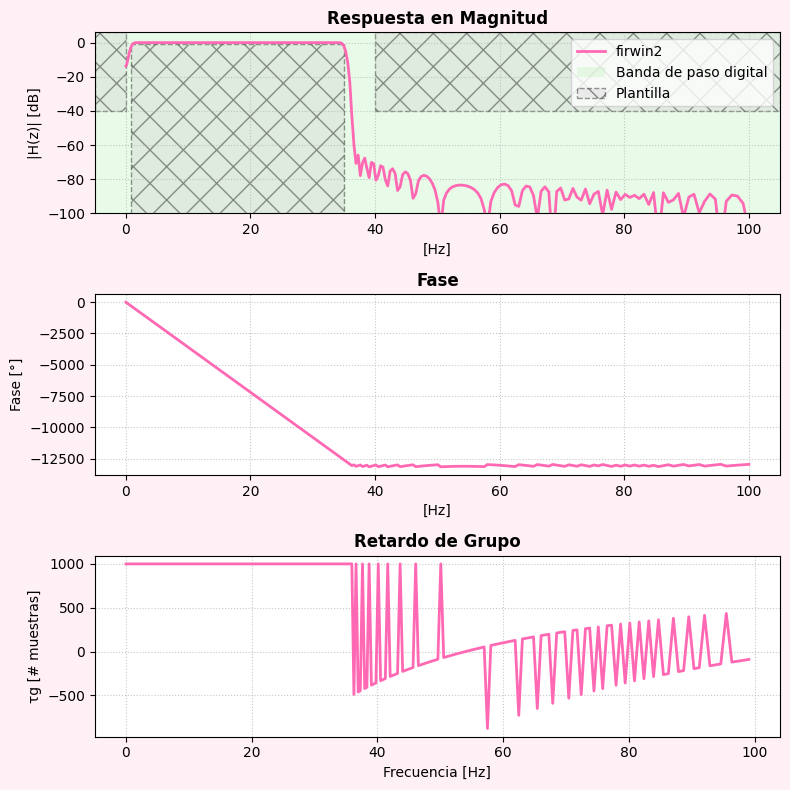

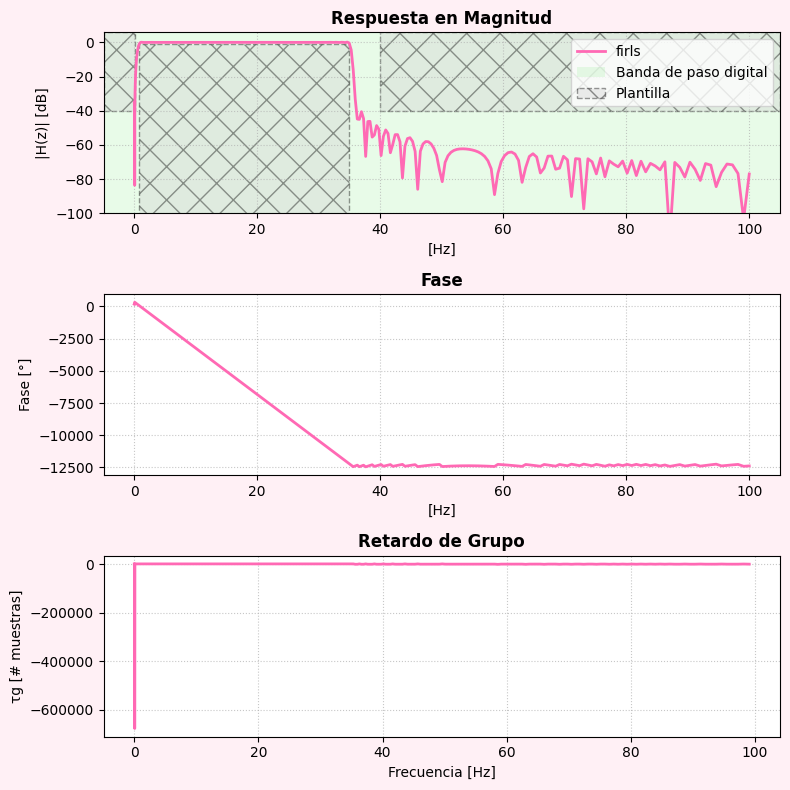

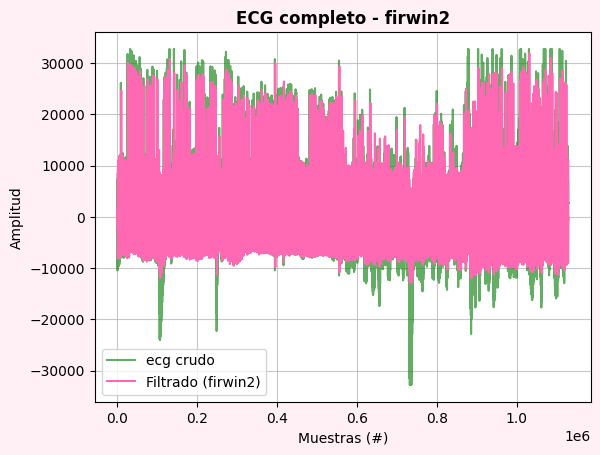

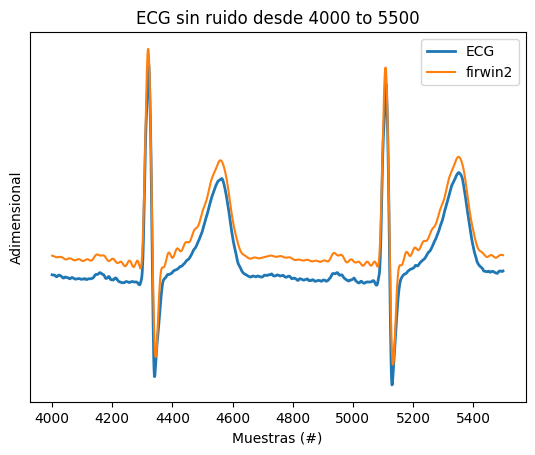

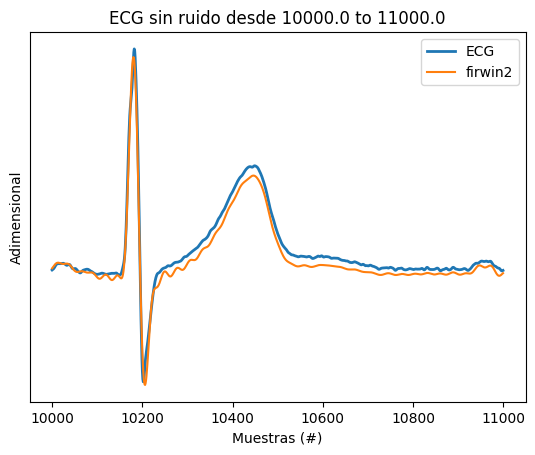

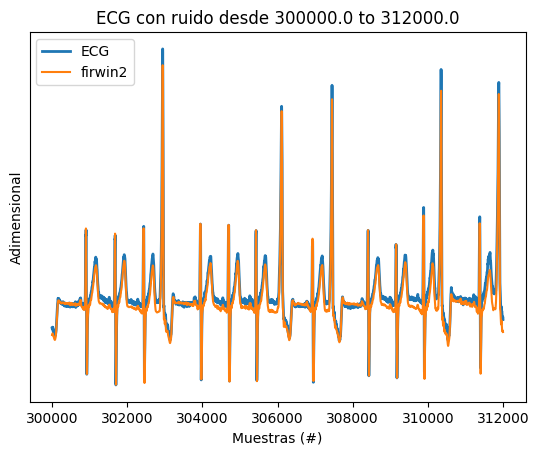

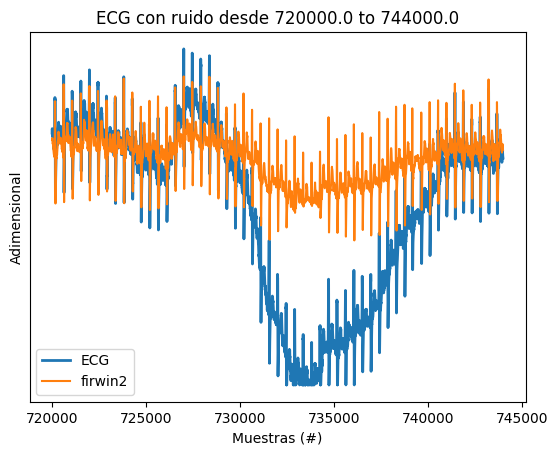

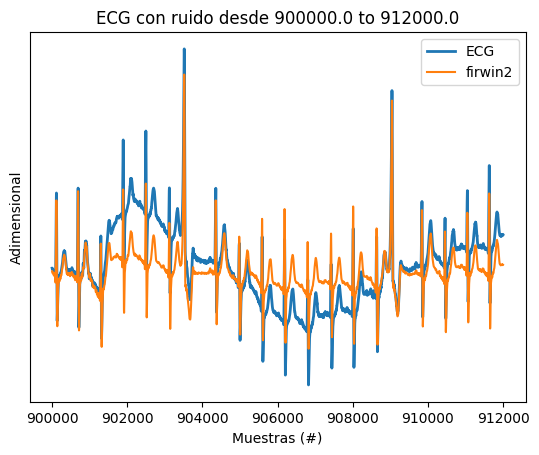

C:\Users\gueva\pepe\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


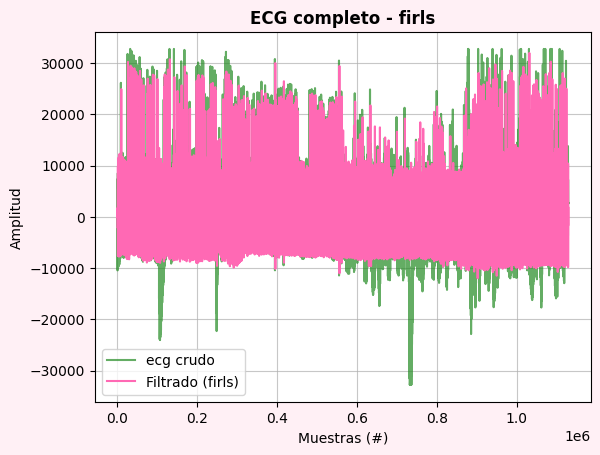

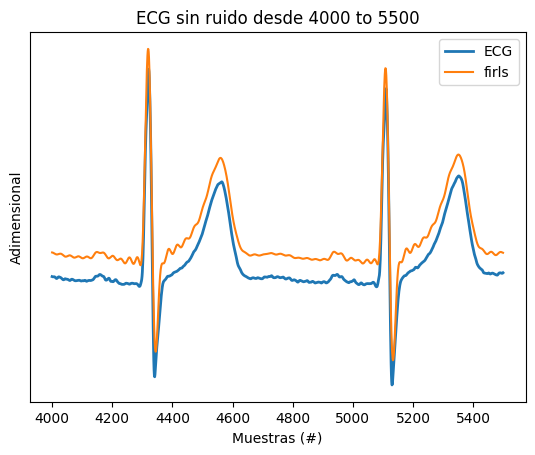

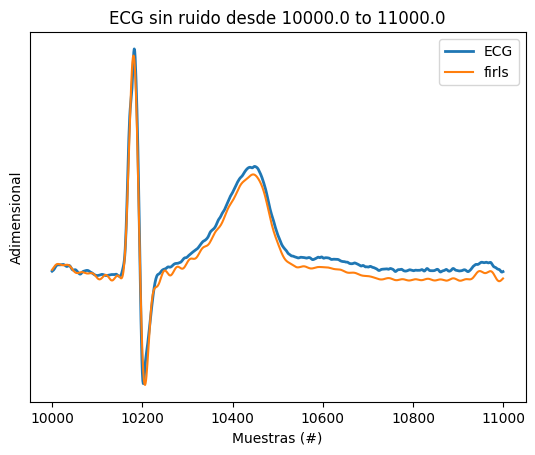

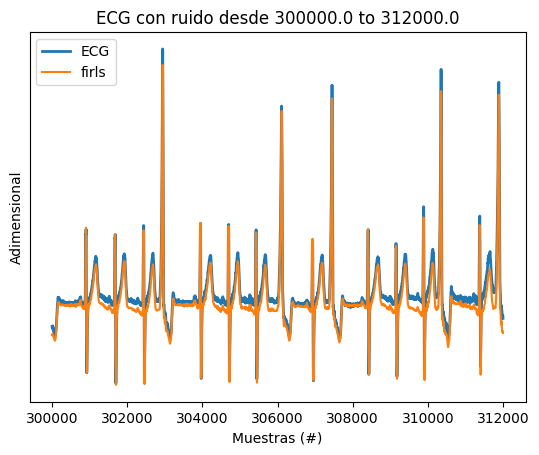

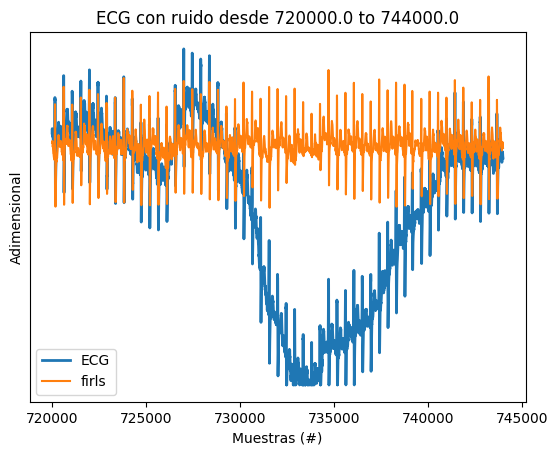

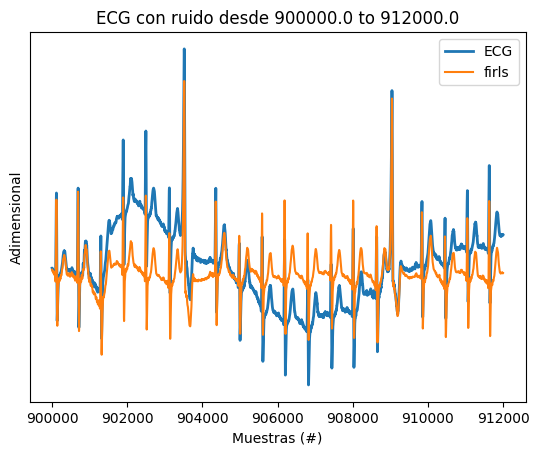

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  4 14:01:06 2025

@author: gueva
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
from scipy.signal import firwin2, freqz, firls
from pytc2.sistemas_lineales import plot_plantilla

#%% CAMBIOS ESTETICOS
plt.style.use('default')  #se resetea
#defino colores
COLOR_FONDO = '#FFF0F5'  
COLOR_VERDE = '#2E8B57'   
COLOR_ROSA = '#FF69B4'    

# %% VARIABLES FIR PARA LA PLANTILLA

fs = 1000 # Hz
fs_ecg = 1000 # Hz
alpha_p = 1/2 #atenuacion de banda de paso / el alfa maximo
alpha_s = 40/2 #atenuacion de banda de rechazo / el alfa minimo
wp = (0.95, 35) #frecuencia de paso, va en rad/s
ws = (0.14, 35.7) #frecuencia de rechazo, va en rad/s

#abro archivo
mat_struct = sio.loadmat('./ecg.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)

#%%
def filtro_FIR(fs, wp, ws, alpha_p, alpha_s, metodo='firwin2'):
    frecuencias = [0, ws[0], wp[0], wp[1], ws[1], fs/2]

    deseado = [0,0,1,1,0,0]
    cant_coef = 2001 if metodo == 'firwin2' else 1999  #esto es por si es impar para fase lineal
    retardo = (cant_coef-1)//2 
    peso = [12,4,4]

    if metodo == 'firwin2':
        b = firwin2(numtaps=cant_coef, freq=frecuencias, gain=deseado, window='hamming', fs=fs)
    elif metodo == 'firls':
        b = firls(numtaps=cant_coef, bands=frecuencias, desired=deseado, fs=fs, weight= peso)
    else:
        raise ValueError("Método inválido.")
    
    #calculo rta en frec
    w, h= freqz(b, worN = np.logspace(-2, 2, 1000), fs = fs)   
    fase = np.unwrap(np.angle(h)) 
    w_rad = 2*np.pi*w/fs
    gd = -np.diff(fase) / np.diff(w_rad) 
    
    #politos y ceritos con la funcion que vimos
    z, p, k = signal.sos2zpk(signal.tf2sos(b,a= 1))
    
    #PLOTEOOO
    plt.figure(figsize=(8,8))
    
    #magnitud
    plt.subplot(3,1,1)
    plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-10)), 
             label=metodo, color=COLOR_ROSA, linewidth=2)
    plot_plantilla(filter_type='bandpass', fpass=(0.8, 35), ripple=alpha_p*2, 
                   fstop=(0.1, 40), attenuation=alpha_s*2, fs=fs)
    plt.title('Respuesta en Magnitud', fontweight='bold')
    plt.ylabel('|H(z)| [dB]')
    plt.xlabel('[Hz]')
    plt.grid(True, which='both', ls=':', alpha=0.7)
    plt.legend()

    #fase
    plt.subplot(3,1,2)
    plt.plot(w, np.degrees(fase), color=COLOR_ROSA, linewidth=2)
    plt.title('Fase', fontweight='bold')
    plt.ylabel('Fase [°]')
    plt.xlabel('[Hz]')
    plt.grid(True, which='both', ls=':', alpha=0.7)
    
    #retardo de grupo
    plt.subplot(3,1,3)
    plt.plot(w[:-1], gd, color=COLOR_ROSA, linewidth=2)
    plt.title('Retardo de Grupo', fontweight='bold')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [# muestras]')
    plt.grid(True, which='both', ls=':', alpha=0.7)

    # Aplicar color de fondo a toda la figura
    plt.gcf().patch.set_facecolor(COLOR_FONDO)
    plt.tight_layout()
    plt.show()
    
    return b, retardo

def filtrar_FIR_ECG(b, nombre_filtro, ecg, fs, retardo):

    ecg_filt = signal.lfilter(b = b, a = 1, x = ecg)

    plt.figure()
    plt.plot(ecg, label='ecg crudo', alpha=0.7, color='forestgreen')
    plt.plot(ecg_filt, label=f'Filtrado ({nombre_filtro})', 
             linewidth=1.5, color=COLOR_ROSA)
    plt.title(f'ECG completo - {nombre_filtro}', fontweight='bold')
    plt.xlabel('Muestras (#)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True, alpha=0.7)
    # Color de fondo
    plt.gcf().patch.set_facecolor(COLOR_FONDO)
    plt.show()

#COPY PASTE DE LA PARTE DE MARIANO DEL CAMPUS
    #################################
    # Regiones de interés sin ruido #
    #################################
    
    cant_muestras = len(ecg_one_lead)
    
    regs_interes = (
            [4000, 5500], # muestras
            [10e3, 11e3], # muestras
            )
     
    for ii in regs_interes:
       
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
       
        plt.figure()
        plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, ecg_filt[zoom_region + retardo], label=nombre_filtro)

        plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
       
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
               
        plt.show()
     
    #################################
    # Regiones de interés con ruido #
    #################################
     
    regs_interes = (
            np.array([5, 5.2]) *60*fs, # minutos a muestras
            np.array([12, 12.4]) *60*fs, # minutos a muestras
            np.array([15, 15.2]) *60*fs, # minutos a muestras
            )
     
    for ii in regs_interes:
       
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
       
        plt.figure()
        plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, ecg_filt[zoom_region + retardo], label=nombre_filtro)
       
        plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
       
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
               
        plt.show()
    
#para comparar ambos filtros fir
metodos_fir = ['firwin2', 'firls']
resultados_fir = {}

for metodo_actual in metodos_fir:
    coeficientes, retardo = filtro_FIR(
        fs=fs, 
        wp=wp, 
        ws=ws, 
        alpha_p=alpha_p, 
        alpha_s=alpha_s, 
        metodo=metodo_actual
    )
    resultados_fir[metodo_actual] = (coeficientes, retardo)

#filtro cada metodo
for nombre_metodo, (coef_filtro, retardo_temporal) in resultados_fir.items():
    filtrar_FIR_ECG(coef_filtro, nombre_metodo, ecg_one_lead, fs_ecg, retardo_temporal)

# Análisis
Los filtros IIR mostraron ser altamente selectivos a órdenes relativamente bajos, lo que se reflejó en transiciones más abruptas y buena atenuación de interferencias, especialmente en el caso del filtro Cauer. No obstante, su fase no lineal generó variaciones en el retardo de grupo que pueden distorsionar un poco la morfología del ECG en transitorios rápidos.

Los filtros FIR presentaron fase estrictamente lineal, manteniendo la forma de onda sin distorsión temporal, pero requirieron de un número muy elevado de coeficientes para alcanzar una selectividad comparable. Esto hizo que se observen retardos más grandes y mayor costo computacional. En las regiones con ruido, ambos enfoques lograron mejorar la señal, aunque los FIR preservaron la morfología con mayor fidelidad, mientras que los IIR fueron más eficientes en la supresión de bajas frecuencias.

# Conclusión
Las cuatro técnicas de filtrado implementadas cumplen adecuadamente con los objetivos de atenuar las fluctuaciones de baja frecuencia en el ECG. Los filtros IIR resultan más eficientes en términos computacionales y proporcionan una atenuación más agresiva, pero introducen distorsiones en fase que pueden afectar la interpretación clínica de ciertos eventos rápidos. Por otro lado, los métodos FIR ofrecen una mayor preservación morfológica gracias a su fase lineal, por lo que se logró que cumplan más estrictamente la plantilla aunque a costa de una mayor complejidad y mayor retardo.

La comparación puso en evidencia el compromiso clásico entre eficiencia y selectividad en los diseños IIR frente a la fidelidad temporal y la linealidad de fase que caracterizan a los FIR. Esta evaluación nos dió las herramientas para saber elegir, de manera informada, la estrategia de filtrado que mejor se adapte a las exigencias clínicas y computacionales de cada aplicación. 

Resolvimos la tarea con seguridad.
Usamos Chatgpt para correccione ortográficas y ayuda en la prolijidad del código y gráficos.

# Biblografía
- Holton, T. (2021). Digital signal processing: Principles and applications. Cambridge University Press. https://doi.org/10.1017/9781108290050
- NumPy user guide — NumPy v2.3 Manual. (2025). Numpy.org. https://numpy.org/doc/stable/user/index.html
- Signal processing (scipy.signal) — SciPy v1.16.1 Manual. (2025). Scipy.org. https://docs.scipy.org/doc/scipy/reference/signal.html#waveforms